# MobileViT CAM Methods Comparison

Testing 4 CAM methods (GradCAM, GradCAM++, EigenCAM, LayerCAM) with 3 optimal target layers.

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from transformers import AutoImageProcessor, AutoModelForImageClassification
from pytorch_grad_cam import GradCAM, GradCAMPlusPlus, EigenCAM, LayerCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from torchvision.transforms import Compose, Normalize, Resize, CenterCrop, ToTensor
import warnings
warnings.filterwarnings('ignore')

/opt/miniconda3/envs/medgemma/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load Model and Image

In [2]:
# Load MobileViT model
model_path = "Models/Classification/chest-xray"
model = AutoModelForImageClassification.from_pretrained(model_path)
processor = AutoImageProcessor.from_pretrained(model_path)
class_names = [model.config.id2label[i] for i in range(len(model.config.id2label))]

print(f"Model: {model_path}")
print(f"Classes: {class_names}")
model.eval()

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Model: Models/Classification/chest-xray
Classes: ['COVID19', 'NORMAL', 'PNEUMONIA', 'TURBERCULOSIS']


MobileViTForImageClassification(
  (mobilevit): MobileViTModel(
    (conv_stem): MobileViTConvLayer(
      (convolution): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (normalization): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): SiLUActivation()
    )
    (encoder): MobileViTEncoder(
      (layer): ModuleList(
        (0): MobileViTMobileNetLayer(
          (layer): ModuleList(
            (0): MobileViTInvertedResidual(
              (expand_1x1): MobileViTConvLayer(
                (convolution): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
                (normalization): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                (activation): SiLUActivation()
              )
              (conv_3x3): MobileViTConvLayer(
                (convolution): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)

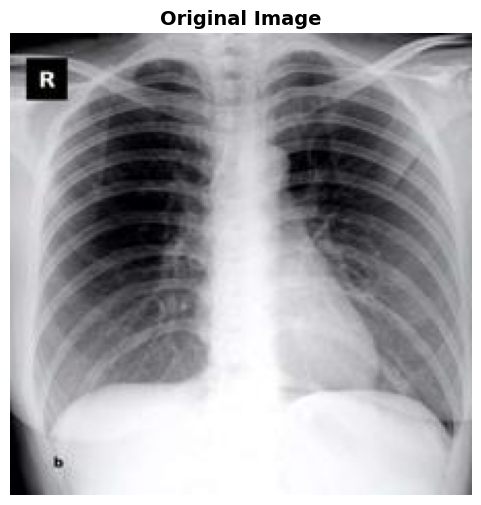

In [3]:
# Load test image
image_path = "Images/Classification/Chest_X-Ray/COVID19(45).jpg"
image = Image.open(image_path).convert("RGB")

plt.figure(figsize=(6, 6))
plt.imshow(image)
plt.title("Original Image", fontsize=14, fontweight='bold')
plt.axis('off')
plt.show()

## Get Predictions

In [4]:
# Preprocess image
size = processor.size.get("shortest_edge", 224) if isinstance(processor.size, dict) else processor.size

if hasattr(processor, 'image_mean') and hasattr(processor, 'image_std'):
    normalize = Normalize(mean=processor.image_mean, std=processor.image_std)
else:
    normalize = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

transforms = Compose([Resize(size), CenterCrop(size), ToTensor(), normalize])
img_tensor = transforms(image)

# Get predictions
with torch.no_grad():
    logits = model(img_tensor.unsqueeze(0)).logits
    probs = torch.softmax(logits, dim=-1)[0].cpu().numpy()

top_idx = int(np.argmax(probs))
top_label = class_names[top_idx]
top_prob = probs[top_idx]

print("\n" + "="*50)
print("PREDICTIONS:")
print("="*50)
for cls, prob in zip(class_names, probs):
    print(f"{cls}: {prob*100:.2f}%")
print("="*50)
print(f"\nTop Prediction: {top_label} ({top_prob*100:.2f}%)")


PREDICTIONS:
COVID19: 99.76%
NORMAL: 0.00%
PNEUMONIA: 0.00%
TURBERCULOSIS: 0.24%

Top Prediction: COVID19 (99.76%)


## Setup CAM Components

### Target Layers for MobileViT

Based on MobileViT architecture analysis, the 3 optimal layers are:

1. **conv_1x1_exp**: Final 1x1 expansion conv layer (640 channels)
   - Most reliable, captures highest-level features
   - Located just before global pooling and classifier
   
2. **last_fusion**: Last MobileViT fusion layer (160 channels)
   - Combines CNN and Transformer features
   - Captures both local and global context
   
3. **last_conv_proj**: Last conv projection layer (160 channels)
   - After transformer processing
   - Good for attention visualization

In [5]:
# Model wrapper for CAM
class HuggingfaceToTensorModelWrapper(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
    
    def forward(self, x):
        return self.model(x).logits

# Prepare inputs
inputs = processor(images=image, return_tensors="pt")
img_tensor_cam = inputs["pixel_values"].squeeze(0)
targets = [ClassifierOutputTarget(top_idx)]
wrapper = HuggingfaceToTensorModelWrapper(model)

# Define 3 optimal target layers
target_layers = {
    'conv_1x1_exp': model.mobilevit.conv_1x1_exp,
    'last_fusion': model.mobilevit.encoder.layer[-1].fusion,
    'last_conv_proj': model.mobilevit.encoder.layer[-1].conv_projection
}

print("Target Layers for MobileViT:")
for name, layer in target_layers.items():
    print(f"  • {name}: {layer.__class__.__name__}")

Target Layers for MobileViT:
  • conv_1x1_exp: MobileViTConvLayer
  • last_fusion: MobileViTConvLayer
  • last_conv_proj: MobileViTConvLayer


## Generate CAM Visualizations

Testing 4 CAM methods × 3 layers = 12 visualizations total

**CAM Methods:**
- **GradCAM**: Classic gradient-based method
- **GradCAM++**: Improved version with better localization
- **EigenCAM**: Uses principal components of activations
- **LayerCAM**: Pixel-wise weighting of activations

**Note:** ScoreCAM excluded (requires 40+ forward passes, too slow)

In [6]:
# CAM methods (excluding ScoreCAM)
cam_methods = {
    'GradCAM': GradCAM,
    'GradCAM++': GradCAMPlusPlus,
    'EigenCAM': EigenCAM,
    'LayerCAM': LayerCAM
}

results = {}

# Generate all combinations
for layer_name, target_layer in target_layers.items():
    print(f"\n{'='*60}")
    print(f"Testing Layer: {layer_name}")
    print(f"{'='*60}")
    
    for method_name, cam_class in cam_methods.items():
        try:
            print(f"  Running {method_name}...", end=' ')
            
            with cam_class(model=wrapper, target_layers=[target_layer]) as cam:
                grayscale_cam = cam(input_tensor=img_tensor_cam.unsqueeze(0), targets=targets)[0, :]
            
            # Store result
            key = f"{layer_name}_{method_name}"
            results[key] = grayscale_cam
            print("✓")
            
        except Exception as e:
            print(f"✗ ({str(e)[:50]}...)")
            results[key] = None

successful = sum(1 for v in results.values() if v is not None)
print(f"\n\n{'='*60}")
print(f"Successfully generated {successful}/12 visualizations")
print(f"{'='*60}")


Testing Layer: conv_1x1_exp
  Running GradCAM... ✓
  Running GradCAM++... ✓
  Running EigenCAM... ✓
  Running LayerCAM... ✓

Testing Layer: last_fusion
  Running GradCAM... ✓
  Running GradCAM++... ✓
  Running EigenCAM... ✓
  Running LayerCAM... ✓

Testing Layer: last_conv_proj
  Running GradCAM... ✓
  Running GradCAM++... ✓
  Running EigenCAM... ✓
  Running LayerCAM... ✓


Successfully generated 12/12 visualizations


## Visualize Results

Display all CAM visualizations in a grid (3 layers × 4 methods)

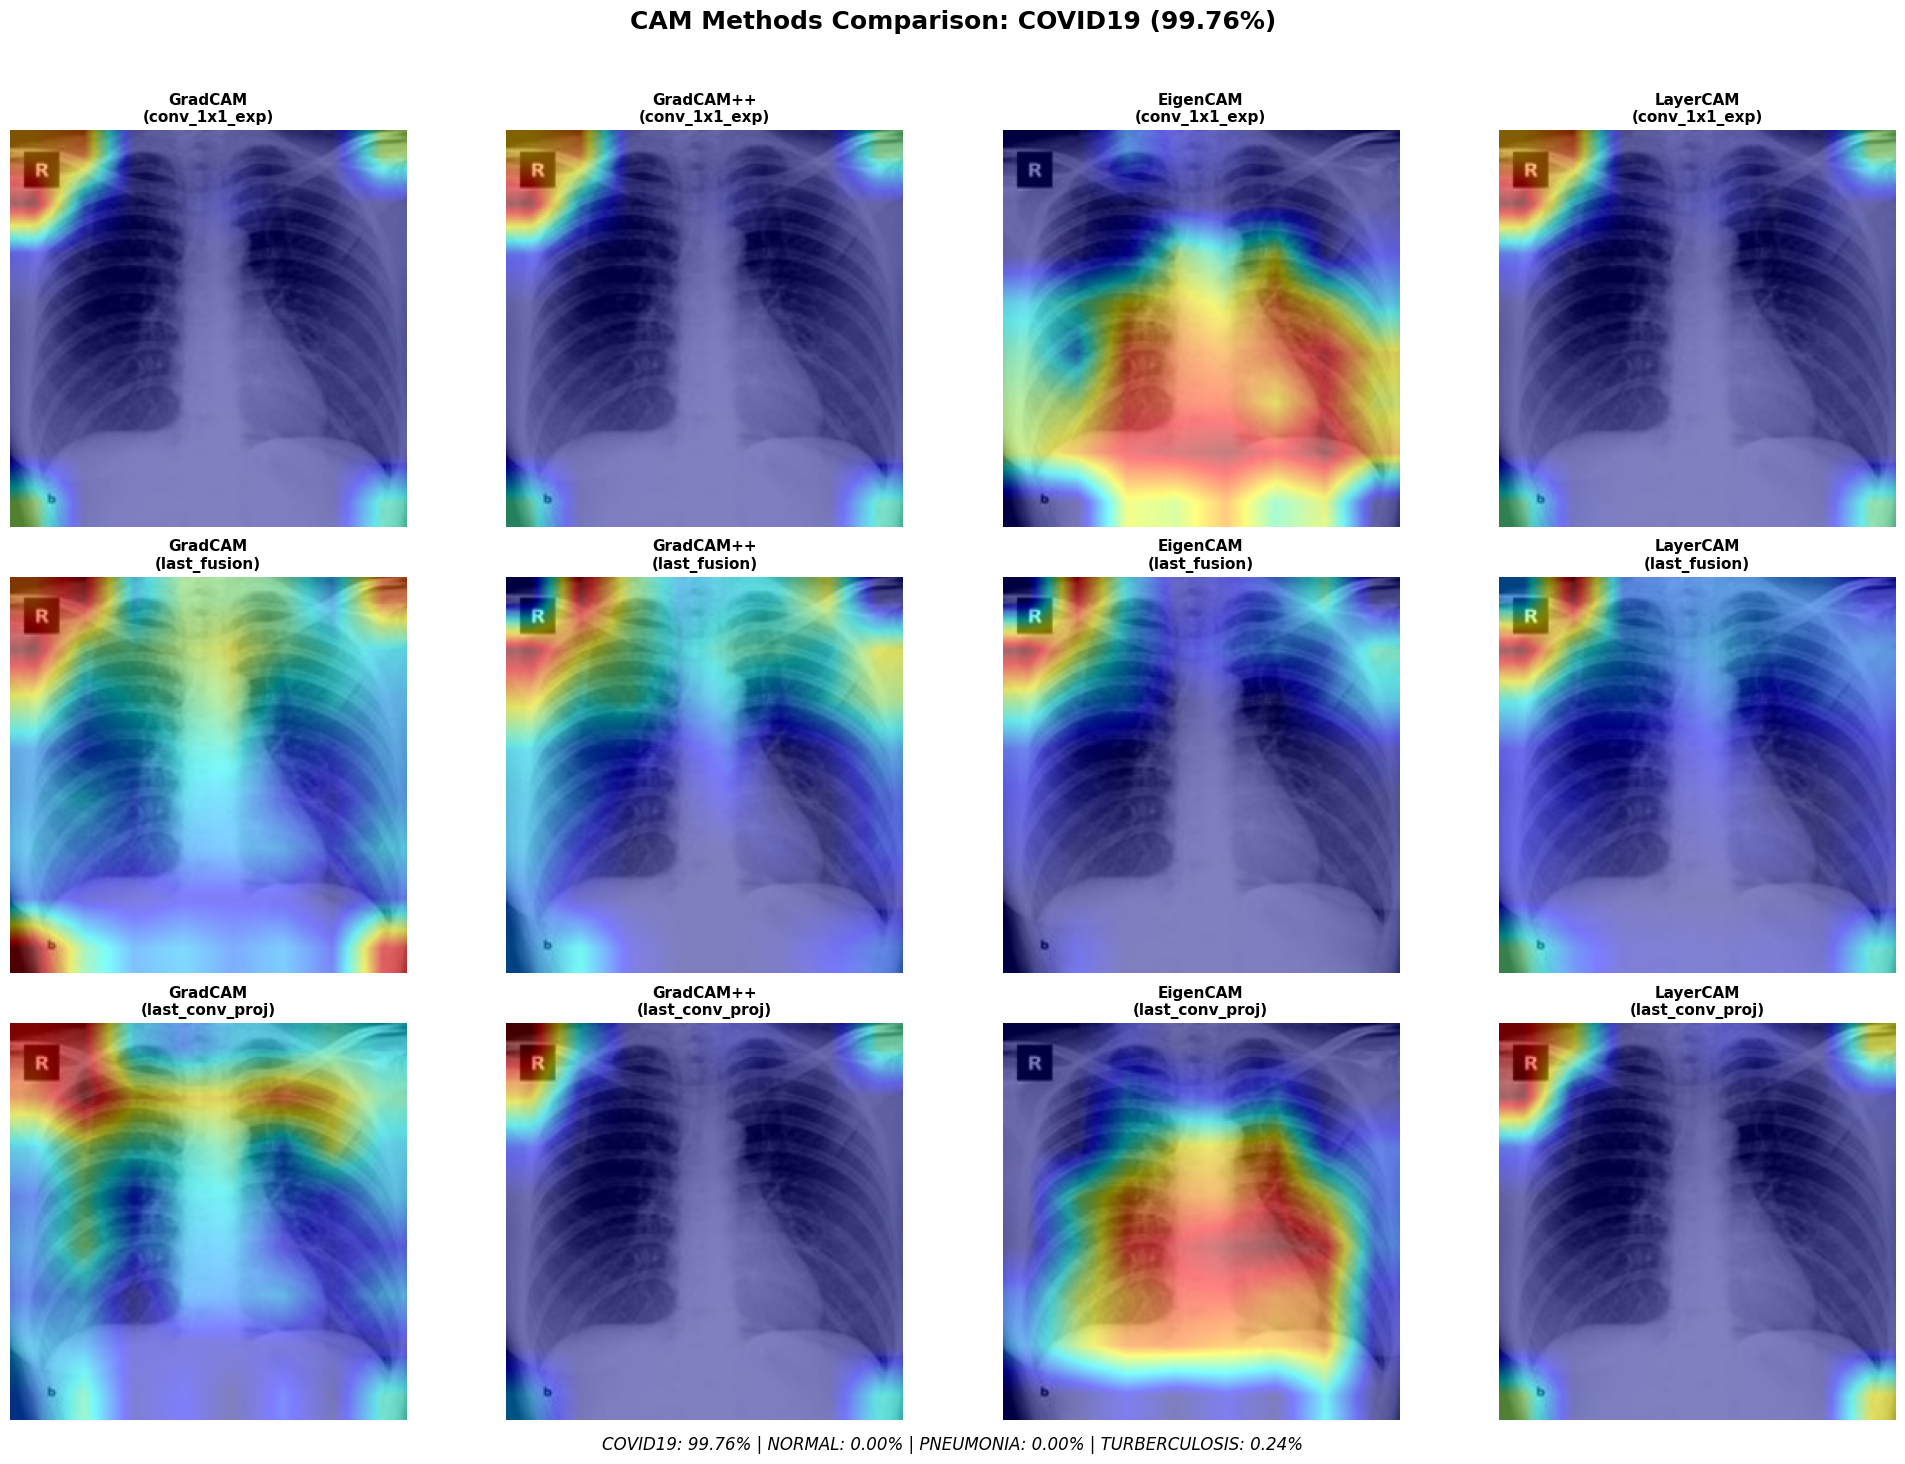

In [7]:
# Create comprehensive visualization grid
rgb_img = np.float32(image.resize((256, 256))) / 255.0

fig, axes = plt.subplots(3, 4, figsize=(20, 15))
fig.suptitle(f'CAM Methods Comparison: {top_label} ({top_prob*100:.2f}%)', 
             fontsize=18, fontweight='bold', y=0.98)

layer_names = list(target_layers.keys())
method_names = list(cam_methods.keys())

for i, layer_name in enumerate(layer_names):
    for j, method_name in enumerate(method_names):
        key = f"{layer_name}_{method_name}"
        ax = axes[i, j]
        
        if results.get(key) is not None:
            cam_img = show_cam_on_image(rgb_img, results[key], use_rgb=True)
            ax.imshow(cam_img)
            ax.set_title(f"{method_name}\n({layer_name})", fontsize=11, fontweight='bold')
        else:
            ax.text(0.5, 0.5, 'Failed', ha='center', va='center', fontsize=14, color='red')
            ax.set_title(f"{method_name}\n({layer_name})", fontsize=11)
        
        ax.axis('off')

# Add prediction legend
legend_text = " | ".join([f"{cls}: {p*100:.2f}%" for cls, p in zip(class_names, probs)])
fig.text(0.5, 0.02, legend_text, ha='center', fontsize=12, style='italic')

plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.show()

## Individual Visualizations

Display each CAM method with original image side-by-side


Layer: conv_1x1_exp



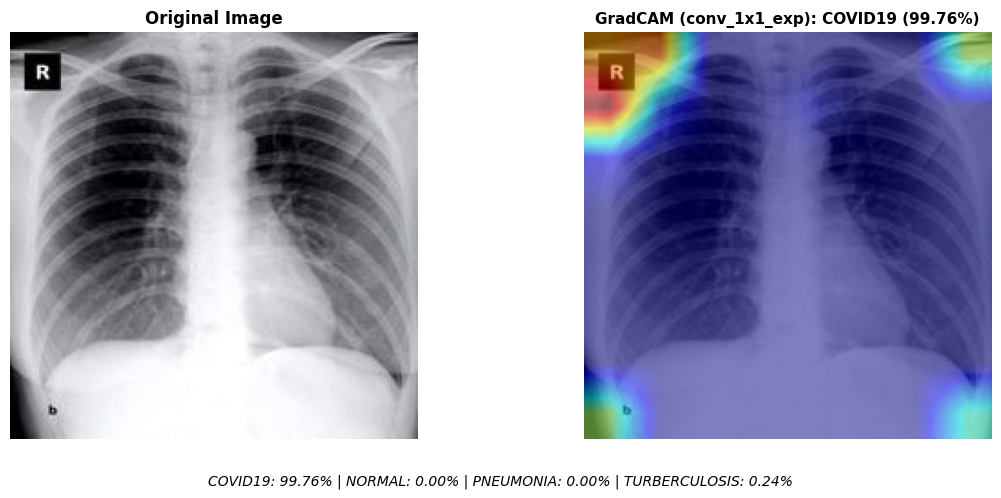

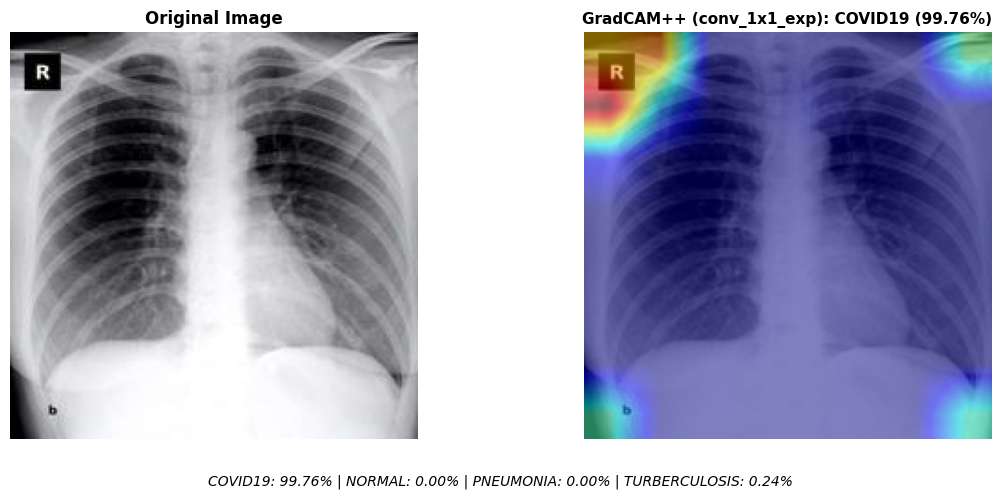

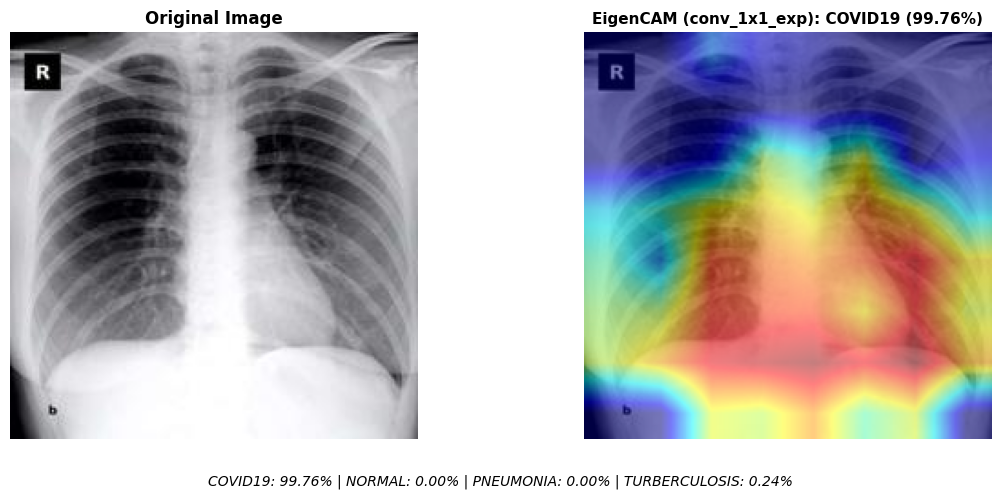

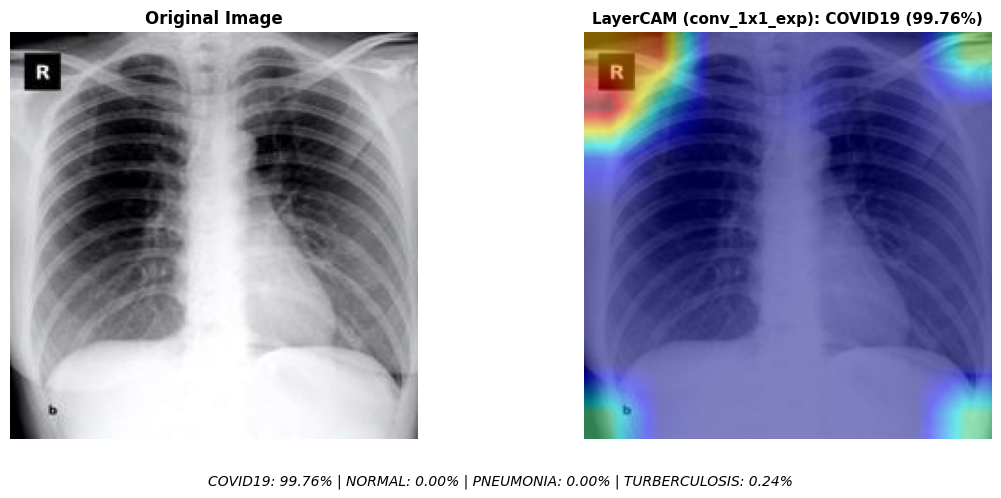


Layer: last_fusion



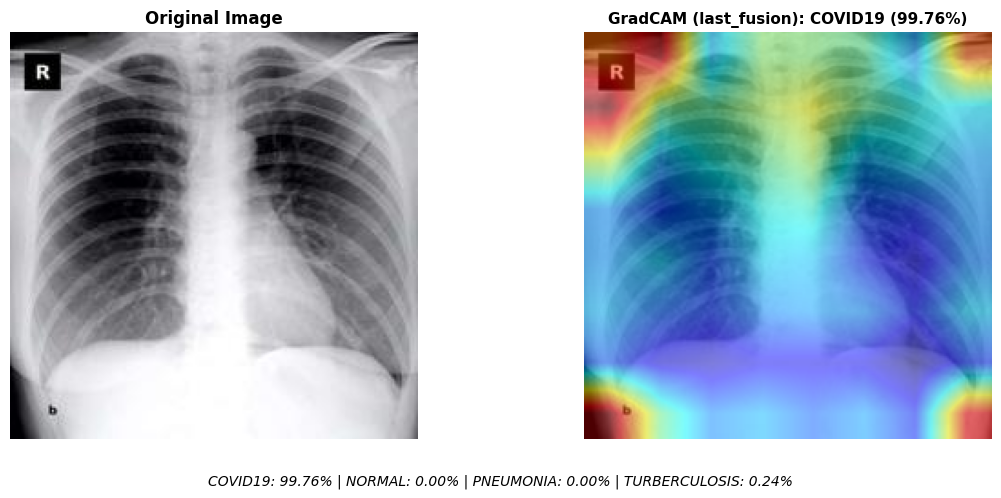

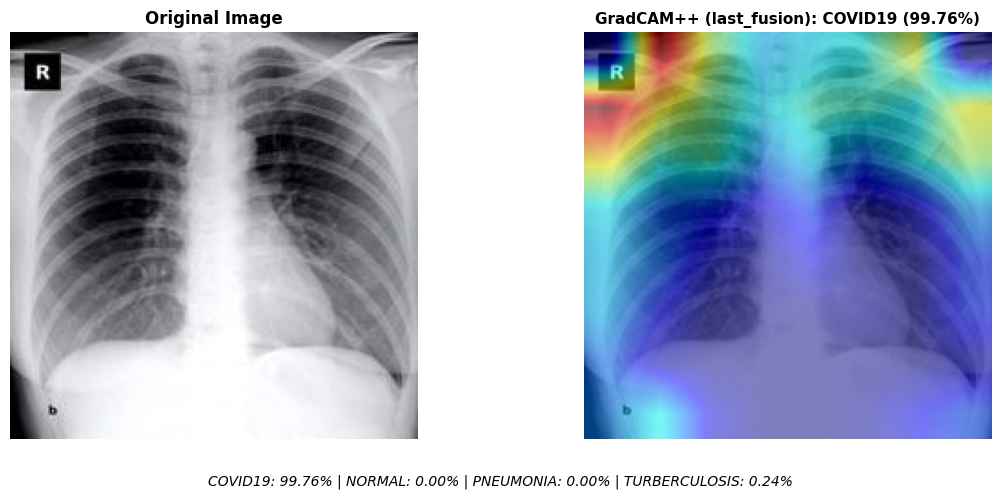

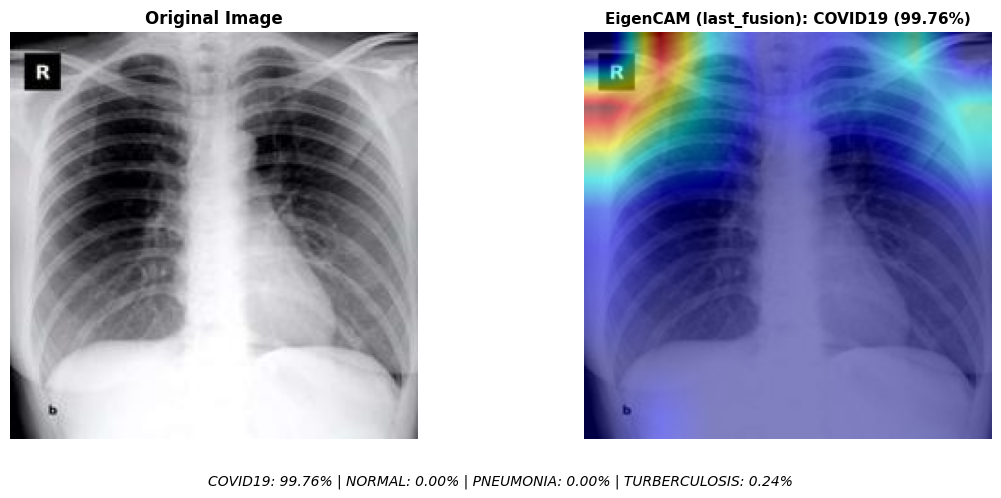

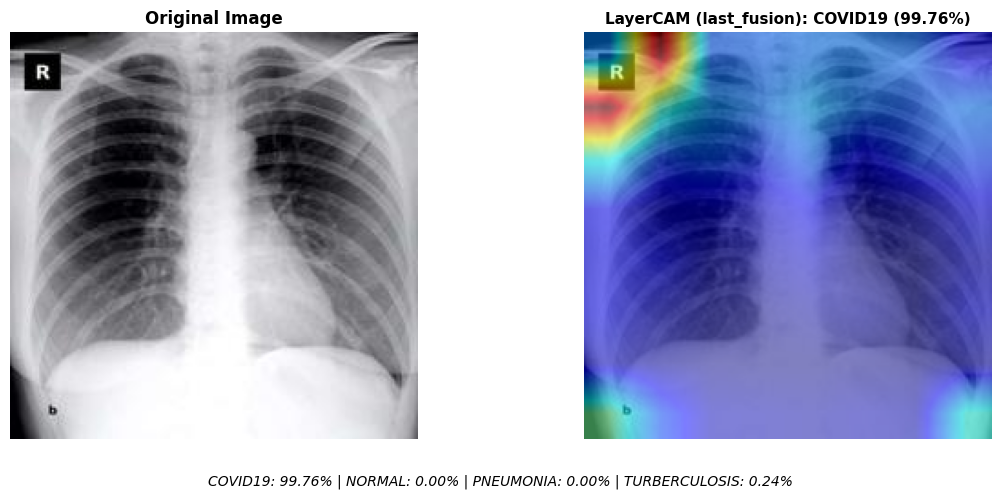


Layer: last_conv_proj



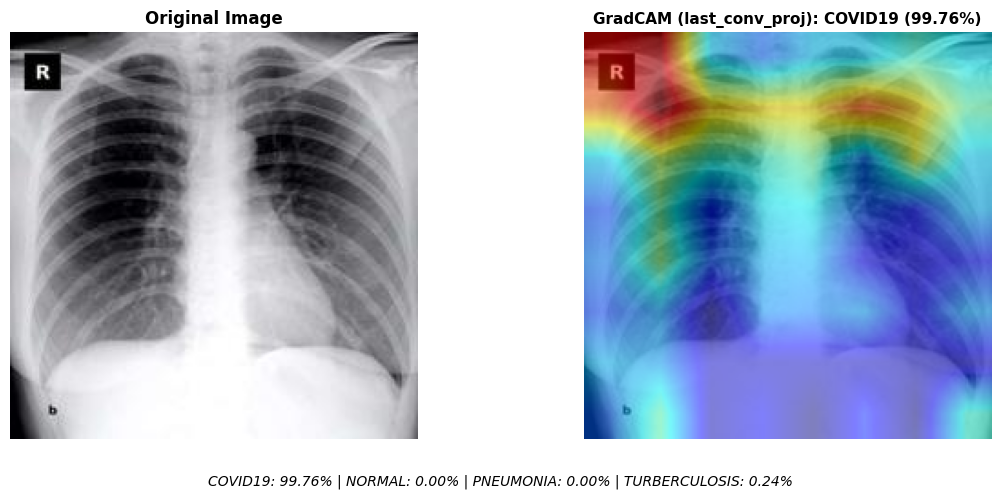

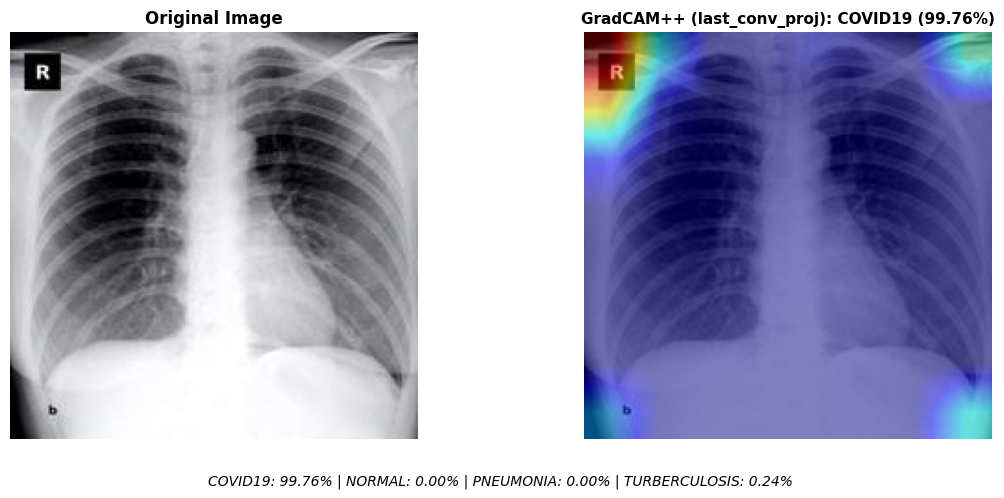

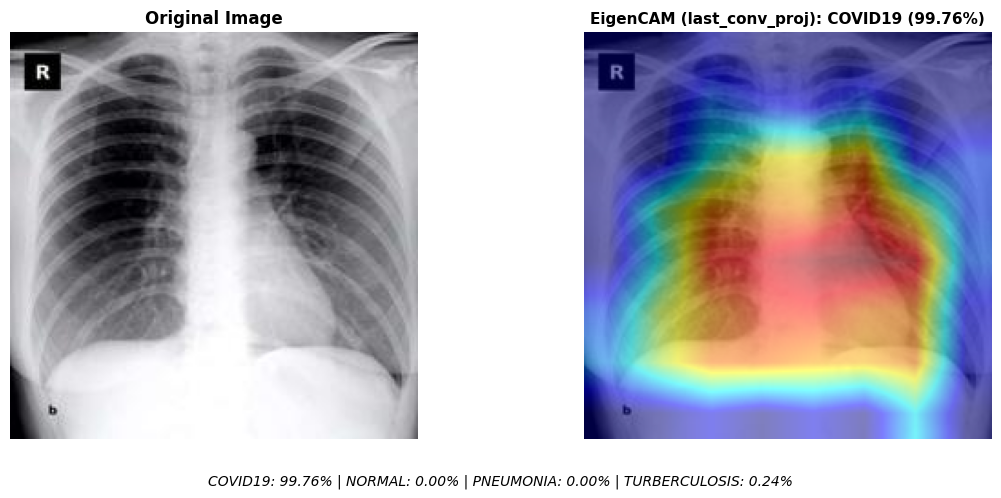

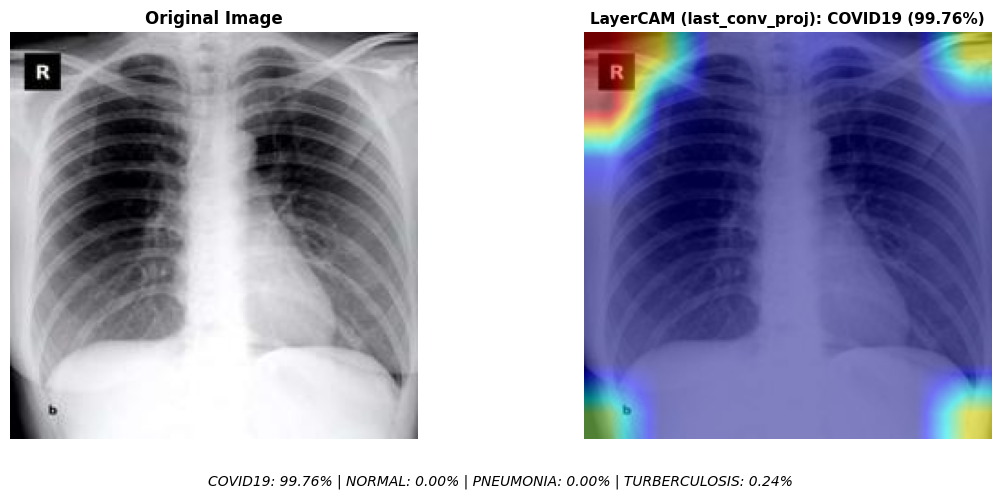

In [8]:
# Display individual comparisons
for layer_name in layer_names:
    print(f"\n{'='*60}")
    print(f"Layer: {layer_name}")
    print(f"{'='*60}\n")
    
    for method_name in method_names:
        key = f"{layer_name}_{method_name}"
        
        if results.get(key) is not None:
            cam_img = show_cam_on_image(rgb_img, results[key], use_rgb=True)
            
            fig, axes = plt.subplots(1, 2, figsize=(12, 5))
            
            axes[0].imshow(image)
            axes[0].set_title("Original Image", fontsize=12, fontweight='bold')
            axes[0].axis('off')
            
            axes[1].imshow(cam_img)
            axes[1].set_title(f"{method_name} ({layer_name}): {top_label} ({top_prob*100:.2f}%)", 
                            fontsize=11, fontweight='bold')
            axes[1].axis('off')
            
            legend_text = " | ".join([f"{cls}: {p*100:.2f}%" for cls, p in zip(class_names, probs)])
            plt.figtext(0.5, 0.02, legend_text, ha="center", fontsize=10, style='italic')
            
            plt.tight_layout(rect=[0, 0.08, 1, 1])
            plt.show()